# Research Question No. 2

## How frequent are, and what are the main characteristics of long-lived bugs in WineHQ project?

## Experimental parameters


| Project                    |         #Reports     |         #Thesholds   |
|----------------------------|:--------------------:|:--------------------:|
| OSS Project                |        WineHQ        |                      |
| Number of Bug Reports      |        10000         |                      |
| Threshold (in days)        |          365         |                      |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup experimental environment.

In [16]:
import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
bug_reports_path = 'datasets/20190912_winehq_bug_report_data.csv'
bug_reports_history_path = 'datasets/20190912_winehq_bug_report_history_data.csv'

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/luiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 2. Load data.

In [17]:

!echo "Header of bug reports file"
!head -n 2 $bug_reports_path

!echo "\nNumber of lines in the file:"
!wc -l $bug_reports_path


Header of bug reports file
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
WINE-38189,2015-03-07,mshtml,WINE,Multiple applications want 'IHTMLDocument2::put_charset' implementation (Yarxi dictionary iPed 7G 2019),"When I start Yarxi 7.5 from http://www.susi.ru/yarxi/ on wine 1.7.38 I have Error OLE erorr 80004001 three times. After clicking on help I have the same error. And main menu buttons didn't appear until I clicked on it. It works good but menu behaivor is annoying. On Windows works perfectly.

Number of lines in the file:
82858 datasets/20190912_winehq_bug_report_data.csv


In [18]:
# read bug reports data.
bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
rows_and_cols = bug_reports_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns.\n")
print(bug_reports_data.info())

# save the dataframe for machine learning experiments.
filename, file_extension = os.path.splitext(bug_reports_path)
bug_reports_data.to_csv(filename + "_small" + file_extension, index=False)

There are 4688 rows and 19 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Data columns (total 19 columns):
bug_id                  4688 non-null object
creation_date           4688 non-null object
component_name          4688 non-null object
product_name            4688 non-null object
short_description       4688 non-null object
long_description        4677 non-null object
assignee_name           4688 non-null object
reporter_name           4688 non-null object
resolution_category     4688 non-null object
resolution_code         4688 non-null int64
status_category         4688 non-null object
status_code             4688 non-null int64
update_date             4688 non-null object
quantity_of_votes       4688 non-null int64
quantity_of_comments    4688 non-null int64
resolution_date         4688 non-null object
bug_fix_time            4688 non-null int64
severity_category       4688 non-null object
severity_code           4688 non-null int64
dtypes:

In [19]:
!echo "Header of bug reports history file"
!head -n 2 $bug_reports_history_path

!echo "\nNumber of lines in the history file:"
!wc -l $bug_reports_history_path


Header of bug reports history file
Key,Who,When,What,Removed,Added
WINE-38189,serjflint,2015-03-07,url,,http://www.susi.ru/yarxi/

Number of lines in the history file:
46677 datasets/20190912_winehq_bug_report_history_data.csv


In [20]:
# read bug reports data.
bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
rows_and_cols = bug_reports_history_data.shape

# print dataframe information.
print(bug_reports_history_data.info())
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns.\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46676 entries, 0 to 46675
Data columns (total 6 columns):
Key        46676 non-null object
Who        46676 non-null object
When       46676 non-null object
What       46676 non-null object
Removed    29325 non-null object
Added      45873 non-null object
dtypes: object(6)
memory usage: 2.1+ MB
None
There are 46676 rows and 6 columns.



## Step 3. Review the data

In [21]:
bug_reports_data.head(10)

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,WINE-38189,2015-03-07,mshtml,WINE,Multiple applications want 'IHTMLDocument2::pu...,When I start Yarxi 7.5 from http://www.susi.ru...,wine-bugs,serjflint,fixed,1,closed,6,2018-10-26,0,14,2018-10-18,1321,normal,2
1,WINE-41103,2016-08-08,oledb32,WINE,Fails to parse Extended Properties since it ha...,Created attachment 55310\ntestcase\n\nWhen you...,wine-bugs,leslie_alistair,fixed,1,closed,6,2016-10-07,0,5,2016-08-09,1,normal,2
2,WINE-878,2002-07-14,-unknown,WINE,Icons arent transparent if Managed='Y',Bug comments restored from Gmane.org: \n \nI...,wine-bugs,us,fixed,1,closed,6,2011-08-08,0,3,2005-03-10,970,normal,2
3,WINE-5673,2006-07-14,-unknown,WINE,Monkey Island 4 (MI4) demo does not install,The MI4 demo uses InstallShield. Everything se...,wine-bugs,daniel.skorka,fixed,1,closed,6,2007-04-03,0,5,2007-04-03,263,normal,2
4,WINE-21644,2010-02-08,-unknown,WINE,Desktop icons created with black background,Hi\n \n+ WildLife Park 2 and\n- Jack Keane\nwe...,wine-bugs,hoehle,fixed,1,closed,6,2010-09-03,0,6,2010-09-01,205,trivial,1
5,WINE-5034,2006-04-09,user32,WINE,Wrong size of commdlg OpenFile dialog in radvi...,The radvideo's (http://www.radgametools.com/do...,wine-bugs,hannibal,fixed,1,closed,6,2009-07-17,0,19,2009-07-07,1185,normal,2
6,WINE-23410,2010-06-27,-unknown,WINE,OnLive fails to connect to service,Created attachment 29187\nWINE command line ou...,wine-bugs,quadomatic,fixed,1,closed,6,2011-07-22,0,11,2011-07-17,385,normal,2
7,WINE-35841,2014-03-22,wmp&wmvcore,WINE,R.U.S.E. Demo need wmvcore.dll.WMCreateSyncRea...,For background movies in the main menu and int...,wine-bugs,andrey.goosev,fixed,1,closed,6,2019-03-15,0,11,2019-03-04,1808,minor,2
8,WINE-30425,2012-04-12,directx-d3dx9,WINE,Toca 3 crashes when start race: D3DXGetImageIn...,Toca 3 crashes whan start race or select car. ...,wine-bugs,robotboy111,fixed,1,closed,6,2012-06-22,0,7,2012-06-08,57,normal,2
9,WINE-23362,2010-06-24,directx-d3d,WINE,The Starcraft 2 Editor crashes when you open t...,Created attachment 29118\nCrash backtrace.\n\n...,wine-bugs,florian,fixed,1,closed,6,2013-08-30,0,13,2013-08-04,1137,minor,2


In [22]:
bug_reports_data.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,4688.0,4688.000000,4688.0,4688.000000,4688.000000,4688.000000
mean,1.0,5.998720,0.0,11.047782,487.821672,2.084258
std,0.0,0.050583,0.0,11.162390,668.691660,0.601491
min,1.0,4.000000,0.0,0.000000,0.000000,1.000000
25%,1.0,6.000000,0.0,5.000000,21.000000,2.000000
50%,1.0,6.000000,0.0,8.000000,211.000000,2.000000
75%,1.0,6.000000,0.0,13.000000,703.000000,2.000000
max,1.0,6.000000,0.0,191.000000,5160.000000,6.000000


In [23]:
bug_reports_history_data.head(10)

,Key,Who,When,What,Removed,Added
0,WINE-38189,serjflint,2015-03-07,url,NaN,http://www.susi.ru/yarxi/
1,WINE-38189,serjflint,2015-03-07,cc,NaN,serjflint
2,WINE-38189,serjflint,2015-03-07,distribution,---,mint
3,WINE-38189,serjflint,2015-03-07,keywords,NaN,integration
4,WINE-38189,bunglehead,2015-03-07,keywords,integration,NaN
5,WINE-38189,bunglehead,2015-03-07,summary,yarxi,yarxi shows error 0x80004001 on startup
6,WINE-38189,bunglehead,2015-03-07,summary,yarxi shows error 0x80004001 on startup,yarxi japanese -> russian dictionary shows err...
7,WINE-38189,bunglehead,2015-03-07,component,-unknown,mshtml
8,WINE-38189,bunglehead,2015-03-07,status,unconfirmed,new
9,WINE-38189,bunglehead,2015-03-07,ever confirmed,0,1


## Step 4. Pre-processing the data

In [29]:
bug_reports_data['short_description'] = bug_reports_data['short_description'].fillna("")
bug_reports_data['long_description']  = bug_reports_data['long_description'].fillna("")
bug_reports_data['short_description_words'] = bug_reports_data['short_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_description_words']  = bug_reports_data['long_description'].str.split().apply(lambda l: len(l))
bug_reports_data['long_lived?']  = bug_reports_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > bug_fix_time_threshold else 'short-lived')


bug_reports_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,short_description_words,long_description_words,long_lived?
0,WINE-38189,2015-03-07,mshtml,WINE,Multiple applications want 'IHTMLDocument2::pu...,When I start Yarxi 7.5 from http://www.susi.ru...,wine-bugs,serjflint,fixed,1,...,2018-10-26,0,14,2018-10-18,1321,normal,2,10,54,long-lived
1,WINE-41103,2016-08-08,oledb32,WINE,Fails to parse Extended Properties since it ha...,Created attachment 55310\ntestcase\n\nWhen you...,wine-bugs,leslie_alistair,fixed,1,...,2016-10-07,0,5,2016-08-09,1,normal,2,12,40,short-lived
2,WINE-878,2002-07-14,-unknown,WINE,Icons arent transparent if Managed='Y',Bug comments restored from Gmane.org: \n \nI...,wine-bugs,us,fixed,1,...,2011-08-08,0,3,2005-03-10,970,normal,2,5,296,long-lived
3,WINE-5673,2006-07-14,-unknown,WINE,Monkey Island 4 (MI4) demo does not install,The MI4 demo uses InstallShield. Everything se...,wine-bugs,daniel.skorka,fixed,1,...,2007-04-03,0,5,2007-04-03,263,normal,2,8,48,short-lived
4,WINE-21644,2010-02-08,-unknown,WINE,Desktop icons created with black background,Hi\n \n+ WildLife Park 2 and\n- Jack Keane\nwe...,wine-bugs,hoehle,fixed,1,...,2010-09-03,0,6,2010-09-01,205,trivial,1,6,267,short-lived


## Step 5. How frequent are long-lived bugs?

[None]

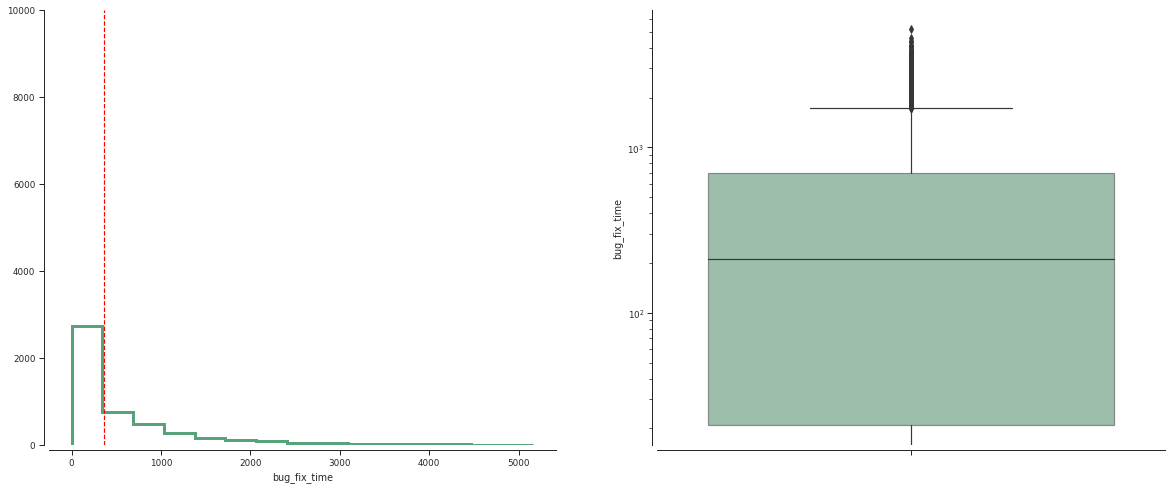

In [30]:
fig, ax = plt.subplots(figsize=(20,8), ncols=2)
sns.despine(offset=5)
sns.color_palette("Paired")

# Long-lived? histogram distribution
g = sns.distplot(bug_reports_data['bug_fix_time']
                 , kde=False
                 , kde_kws={"color": "b", "alpha": 0.5, "lw": 3}, bins=15
                 , hist=True
                 , hist_kws={"histtype": "step", "linewidth": 3,"alpha": 0.8, "color": "seagreen"}
                 , ax=ax[0])
g.set(ylim=(0, 10000))

g.axvline(bug_fix_time_threshold, color='r', linestyle='--'
          , label = f"Threshold : {bug_fix_time_threshold}")

g = sns.boxplot(y="bug_fix_time"
                , data=bug_reports_data
                , showfliers=True, ax=ax[1]
                , palette=["seagreen"]
                , boxprops=dict(alpha=.5)
)
g.set(yscale="log")

([<matplotlib.patches.Wedge at 0x7f47aaa9c2b0>,
 [Text(-0.3274158203954941, 1.050142314429214, 'short-lived'),
  Text(0.32741591871691156, -1.0501422837743277, 'long-lived')],
 [Text(-0.1785904474884513, 0.5728048987795711, '59.6%'),
  Text(0.1785905011183154, -0.5728048820587242, '40.4%')])

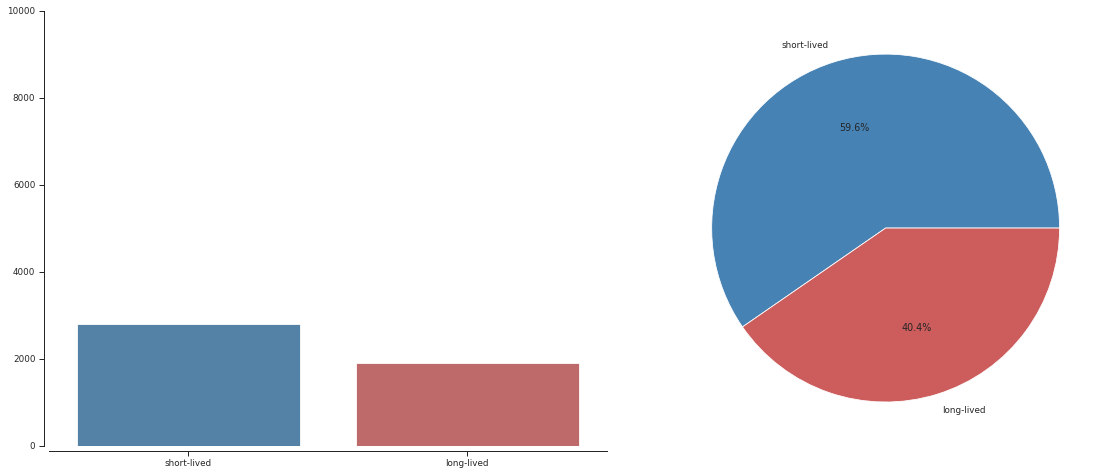

In [31]:
bug_reports_count = bug_reports_data["long_lived?"].value_counts()

# bar plot
f, ax = plt.subplots(figsize=(20,8), ncols=2)
plt.subplots_adjust(wspace=0, hspace=1)
sns.despine(offset=5)
sns.set_palette("deep")
g = sns.barplot(
      x=bug_reports_count.index
    , y=bug_reports_count.values
    , palette=[ "steelblue", "indianred"]
    , ax=ax[0]
)
g.set(ylim=(0, 10000))

# pie plot
ax[1].pie(
    bug_reports_count.values
    , labels=bug_reports_count.index, autopct='%1.1f%%'
    , colors=["steelblue", "indianred"]
)



## Step 6. Bug Reporter

In [32]:
number_of_reports   = bug_reports_data['bug_id'].count()
number_of_reporters = bug_reports_data['reporter_name'].nunique()
print(f"{number_of_reporters} reporters reported {number_of_reports} bugs.")

2203 reporters reported 4688 bugs.


In [33]:
top_10_reporters = bug_reports_data.groupby('reporter_name').reporter_name.agg(['count'])
top_10_reporters = top_10_reporters.sort_values('count', ascending=False)[0:10]
top_10_reporters

,count
reporter_name,
dank,243
austinenglish,236
gyebro69,149
focht,120
imwellcushtymelike,69
fgouget,60
xerox.xerox2000x,58
lukasz.wojnilowicz,49
RandomAccountName,47


[None]

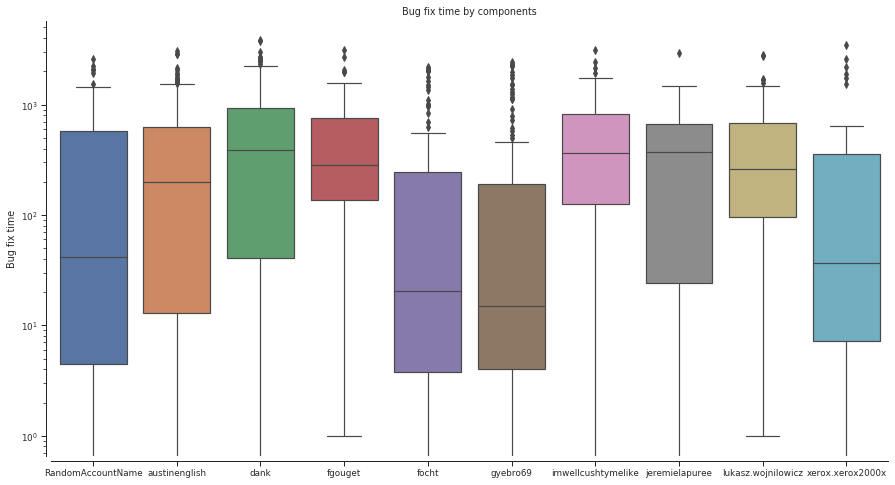

In [34]:
bug_reports_data_for_top_10_reporters=bug_reports_data[bug_reports_data['reporter_name'].isin(top_10_reporters.index)]
bug_reports_data_for_top_10_reporters=bug_reports_data_for_top_10_reporters.sort_values(by=['reporter_name'])

fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
sns.set_palette("deep")
g = sns.boxplot(data=bug_reports_data_for_top_10_reporters
            , x="reporter_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by reporter')]

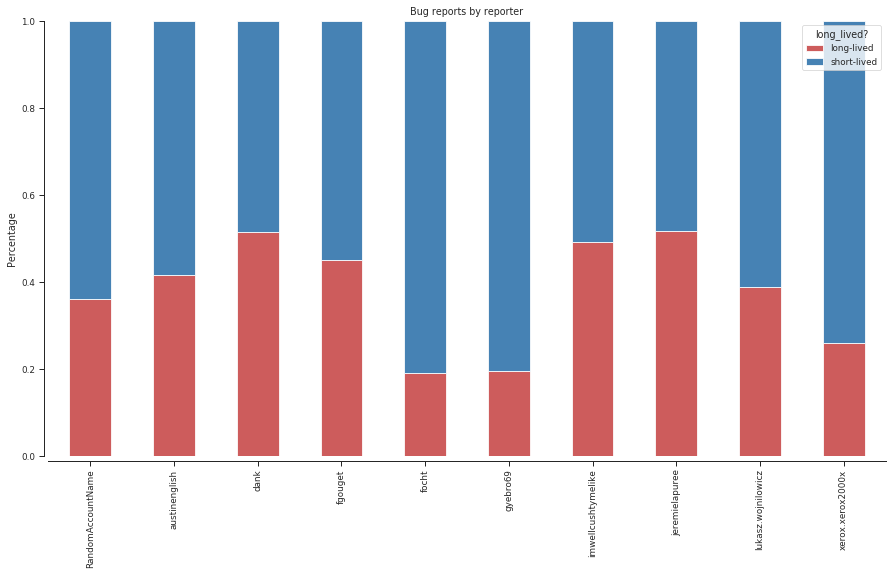

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)

palette=color=["indianred", "steelblue"]
bug_reports_data_grouped = bug_reports_data_for_top_10_reporters.groupby("reporter_name")['long_lived?'].value_counts(normalize=True).unstack()

bug_reports_data_grouped.plot(kind='bar', stacked='True', color=palette, ax=ax)
ax.set(ylim=(0, 1))
ax.set(title="Bug reports by reporter", xlabel="", ylabel="Percentage")


## Step 7. Assignee

In [36]:
top_10_assignee = bug_reports_data.groupby('assignee_name').assignee_name.agg(['count'])
top_10_assignee = top_10_assignee.sort_values('count', ascending=False)[0:10]
top_10_assignee

,count
assignee_name,
wine-bugs,4409
jnewman,28
mike,19
us,18
truiken,12
eric.pouech,11
fgouget,9
00cpxxx,9
dpaun,8


[None]

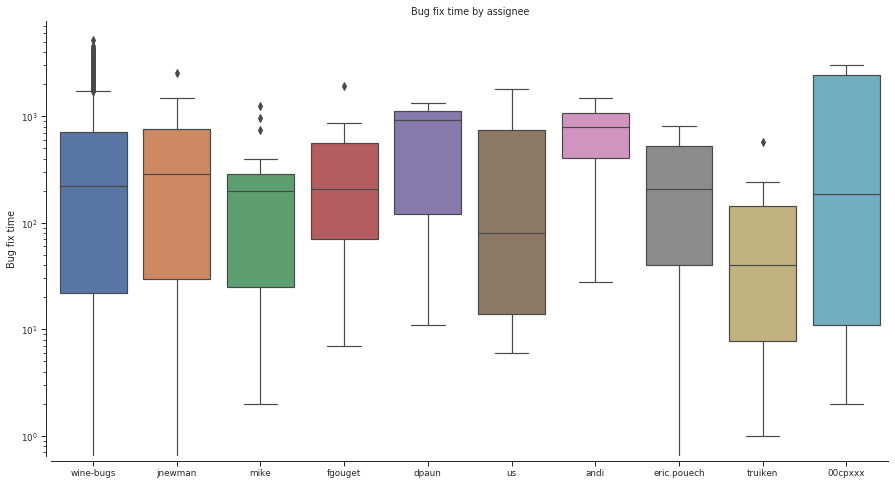

In [37]:
fig, ax = plt.subplots(figsize=(15,8))
bug_reports_data_for_top_10_assignee=bug_reports_data[bug_reports_data['assignee_name'].isin(top_10_assignee.index)] 

sns.despine(offset=5)
g = sns.boxplot(data=bug_reports_data_for_top_10_assignee
            , x="assignee_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by assignee", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by assignee')]

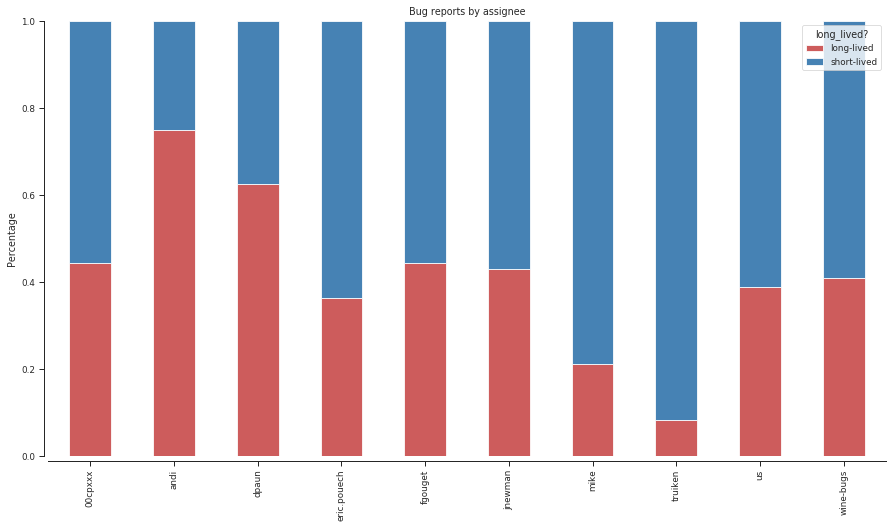

In [38]:
bug_reports_data_grouped = bug_reports_data_for_top_10_assignee.groupby("assignee_name")['long_lived?'].value_counts(normalize=True).unstack()

# stacked bar plot.
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=["indianred", "steelblue"], ax=ax)
ax.set(ylim=(0, 1))
ax.set(title="Bug reports by assignee", xlabel="", ylabel="Percentage")

## Step 8. Component

In [39]:
top_10_component = bug_reports_data.groupby('component_name').component_name.agg(['count'])
top_10_component = top_10_component.sort_values('count', ascending=False)[0:10]
top_10_component

,count
component_name,
-unknown,1632
directx-d3d,460
kernel32,126
user32,124
msi,121
winex11.drv,119
comctl32,116
gdi32,115
msvcrt,111


[None]

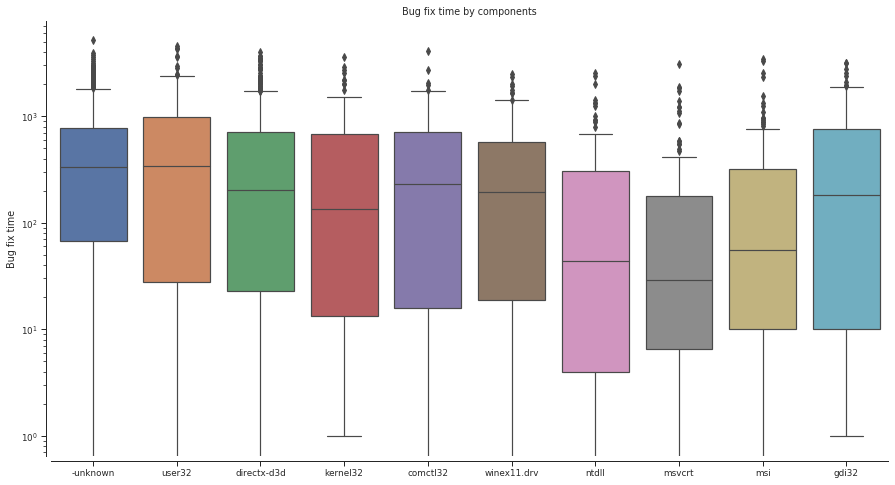

In [40]:
bug_reports_data_for_top_10_component=bug_reports_data[bug_reports_data['component_name'].isin(top_10_component.index)] 

# plot boxplot chart
fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
g = sns.boxplot(data=bug_reports_data_for_top_10_component
            , x="component_name"
            , y="bug_fix_time"
            , showfliers=True)
g.set(title="Bug fix time by components", xlabel="", ylabel="Bug fix time")
g.set(yscale="log")

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Bug reports by components')]

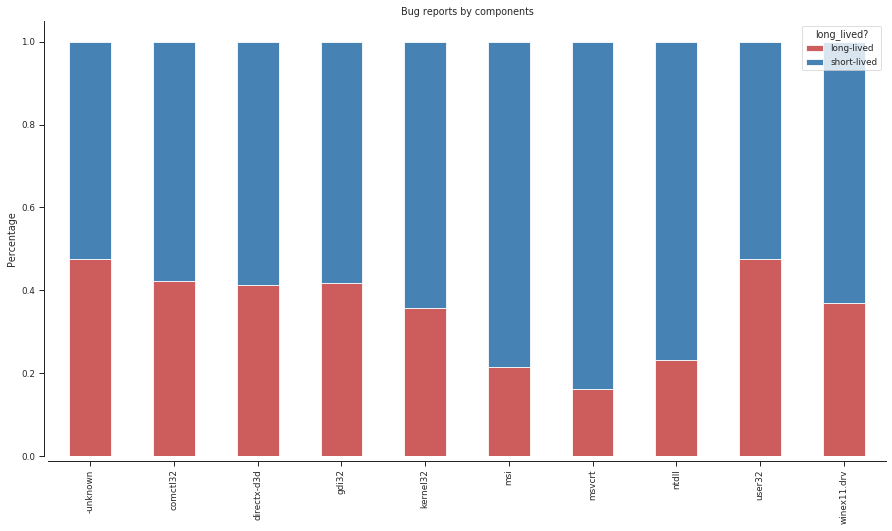

In [41]:
# group data.
bug_reports_data_grouped = bug_reports_data_for_top_10_component.groupby("component_name")['long_lived?'].value_counts(normalize=True).unstack()


fig, ax = plt.subplots(figsize=(15,8))
sns.despine(offset=5)
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=["indianred", "steelblue"], ax=ax)
ax.set(title="Bug reports by components", xlabel="", ylabel="Percentage")

## Step 9. Analysis of Short and Long Descrption

### How is the distribution of number of words

Text(0, 0.5, 'Density')

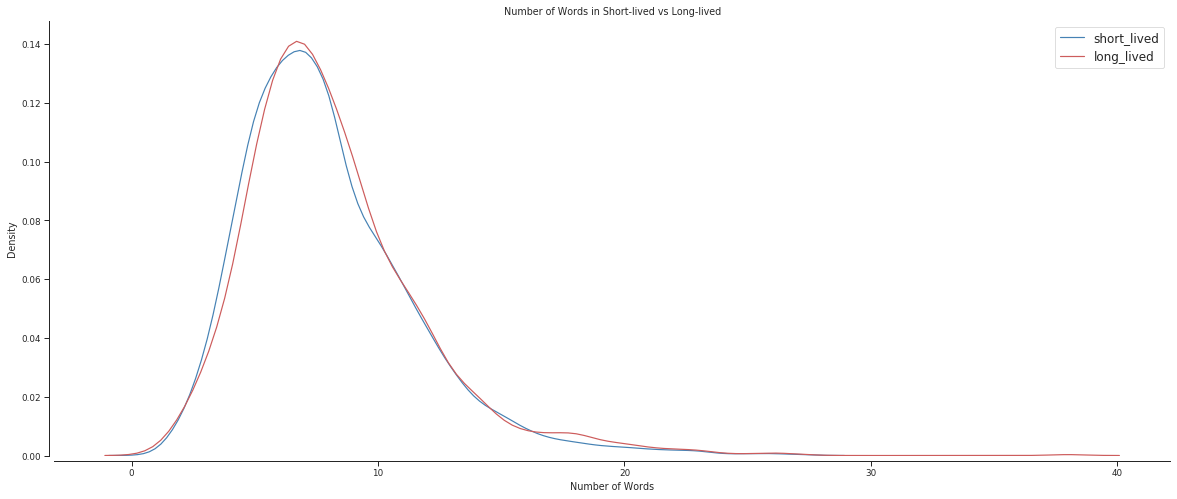

In [43]:
plt.subplots(figsize=(20,8), ncols=1)
sns.despine(offset=5)

data = bug_reports_data[bug_reports_data["long_lived?"]=="short-lived"]
g = sns.distplot(data["short_description_words"], hist=False
                 , kde=True, kde_kws={"color": "steelblue"}
                 , label="short_lived")

data = bug_reports_data[bug_reports_data["long_lived?"]=="long-lived"]
g = sns.distplot(data["short_description_words"], hist=False
                 , kde=True, kde_kws={"color": "indianred"}
                 , label="long_lived")

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Number of Words in Short-lived vs Long-lived')
plt.xlabel('Number of Words')
plt.ylabel('Density')  

Text(0, 0.5, 'Density')

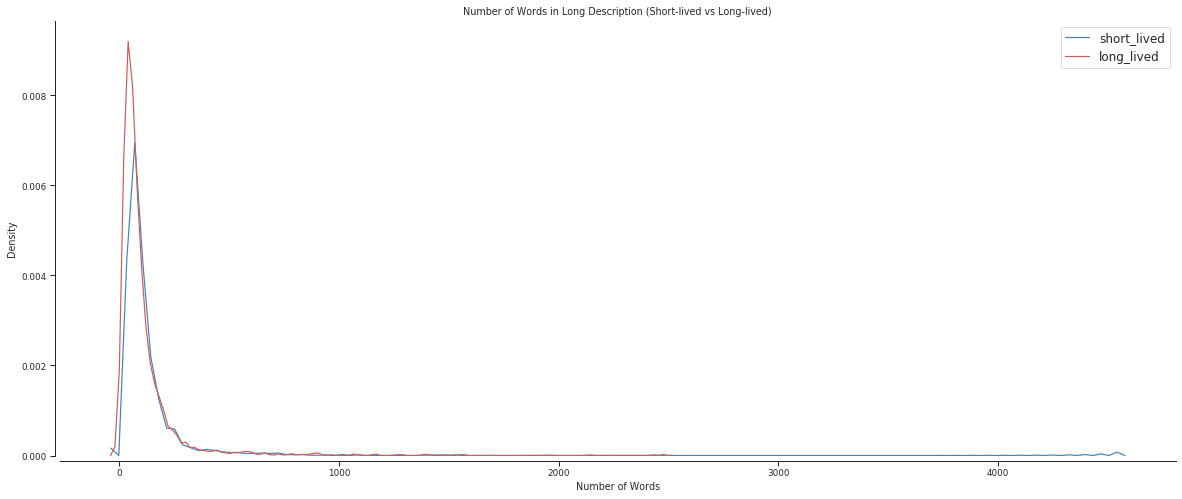

In [44]:
plt.subplots(figsize=(20,8), ncols=1)
sns.despine(offset=5)

data = bug_reports_data[bug_reports_data["long_lived?"]=="short-lived"]
g = sns.distplot(data["long_description_words"], hist=False
                 , kde=True, kde_kws={"color": "steelblue"}
                 , label="short_lived")

data = bug_reports_data[bug_reports_data["long_lived?"]=="long-lived"]
g = sns.distplot(data["long_description_words"], hist=False
                 , kde=True, kde_kws={"color": "indianred"}
                 , label="long_lived")

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Number of Words in Long Description (Short-lived vs Long-lived)')
plt.xlabel('Number of Words')
plt.ylabel('Density')  

### Short Description Word cloud

In [57]:
def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    else:
        sl_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title)
    axe.axis("off")

def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
        
    return "".join(stem_sentence)

def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['wine', 'dll', 'window', 'project'
                           , 'view', 'editor', 'file', 'test'
                           , 'update', 'will', 'crashes'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, 'Word Cloud for {} [Short-Lived Bugs]'.format(title), ax[0])
    plot_one_word_cloud(ll_text, 'Word Cloud for {} [Long-Lived Bugs]'.format(title), ax[1])


    

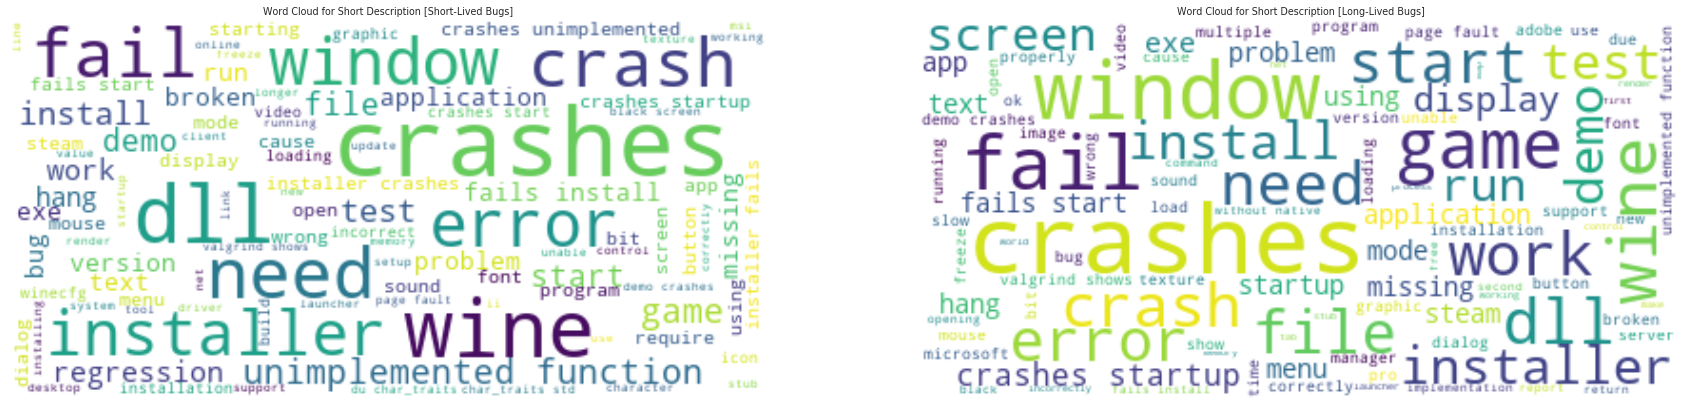

In [58]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description')

### Short Description Word cloud with Text Mining

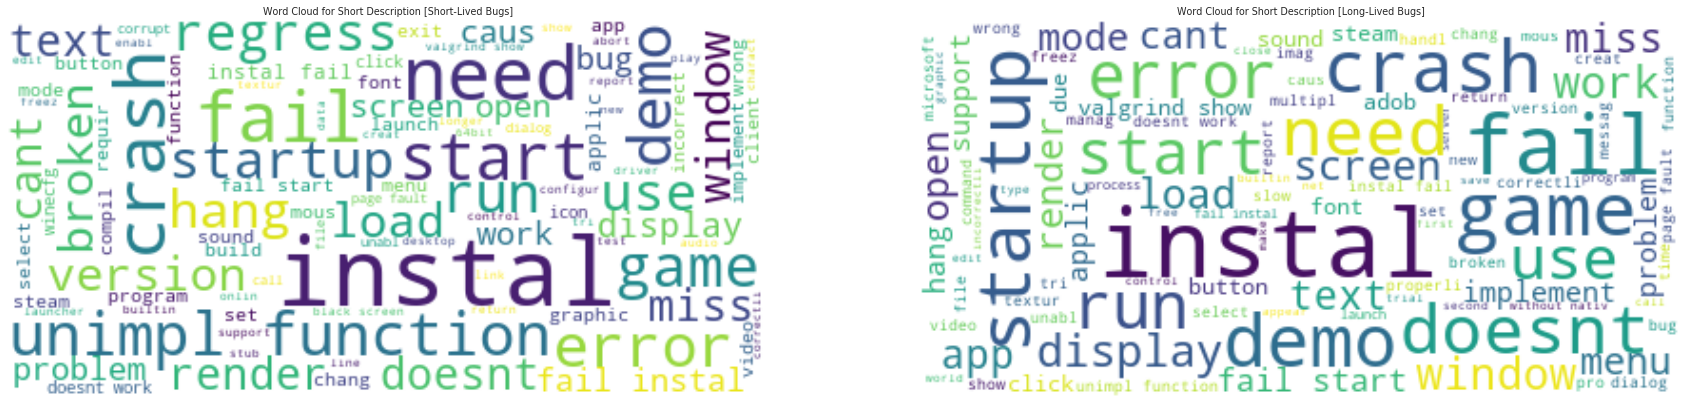

In [59]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].short_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].short_description,
                    'Short Description', True)

### Long Description Word cloud

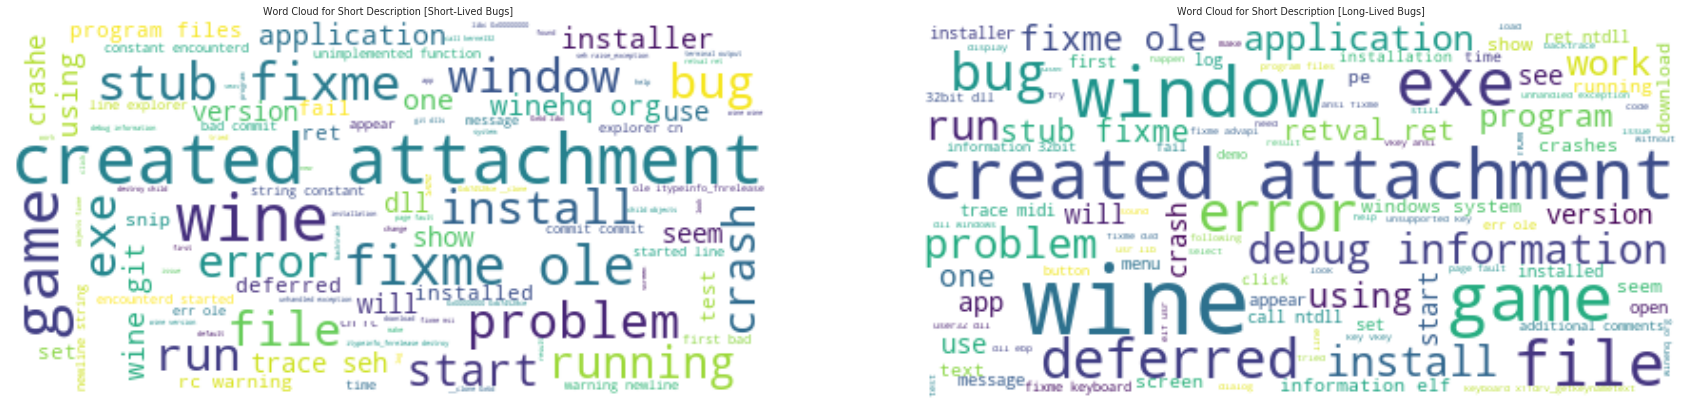

In [60]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Short Description', False)

### Long Description Word cloud with Text Mining

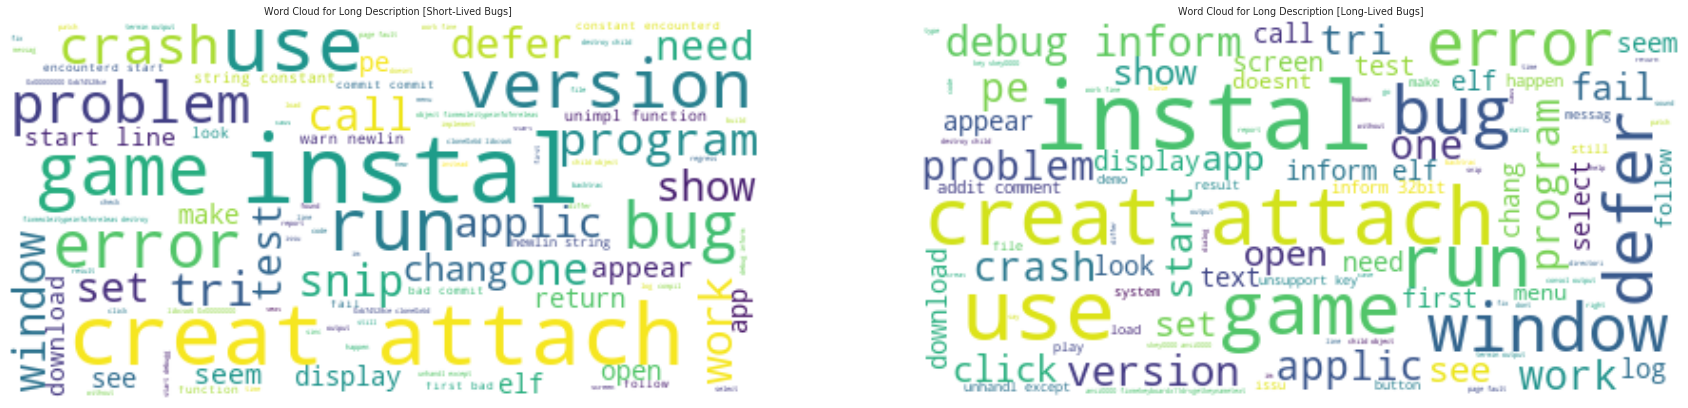

In [61]:
plot_all_word_clouds(bug_reports_data[bug_reports_data['long_lived?']=='short-lived'].long_description,
                     bug_reports_data[bug_reports_data['long_lived?']=='long-lived'].long_description,
                    'Long Description', True)

## Step 10. Analysis of Severity Level

### Severity level distribution

[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of severity level')]

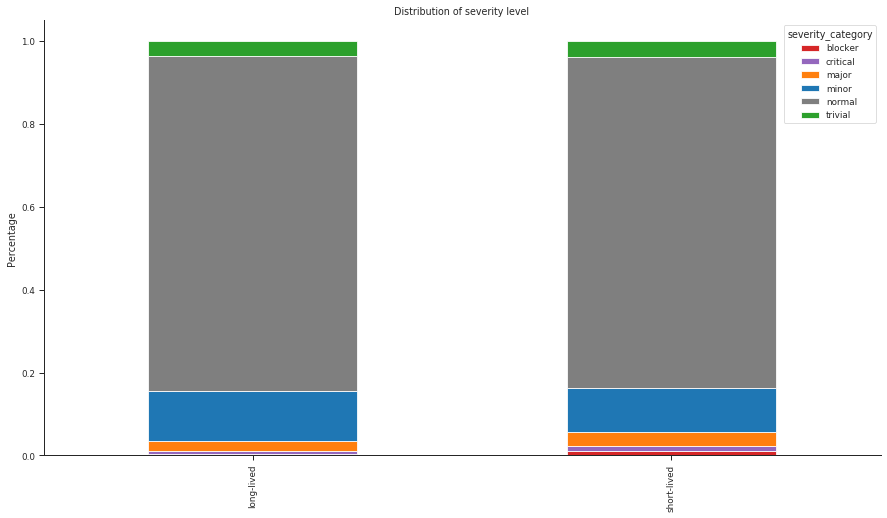

In [62]:
fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["tab:red", "tab:purple", "tab:orange", "tab:blue", "tab:gray", "tab:green"]
bug_reports_data_grouped = bug_reports_data.groupby("long_lived?")['severity_category'].value_counts(normalize=True).unstack()
bug_reports_data_grouped.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of severity level", xlabel="", ylabel="Percentage")


[None]

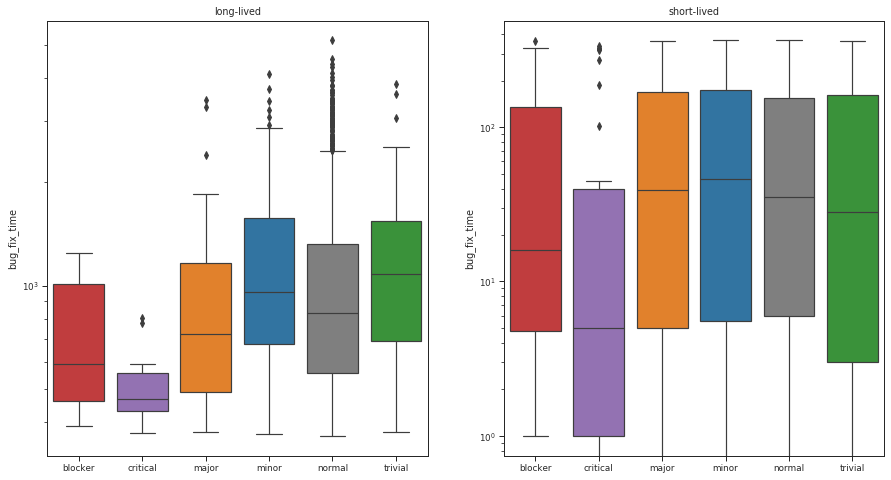

In [64]:
fig, ax = plt.subplots(figsize=(15,8), ncols=2)

g1 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='long-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[0])
g1.set(title="long-lived", xlabel="")
g1.set(yscale="log")

g2 = sns.boxplot(data=bug_reports_data[bug_reports_data['long_lived?']=='short-lived']
                 , x="severity_category", y="bug_fix_time"
                , order=['blocker', 'critical', 'major', 'minor', 'normal', 'trivial']
                , palette=severity_palette
                , showfliers=True
                , ax=ax[1])
g2.set(title="short-lived", xlabel="")
g2.set(yscale="log")


### Number of Changes

/home/luiz/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/luiz/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


[Text(0, 0.5, 'Percentage'),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Distribution of changes in severity level')]

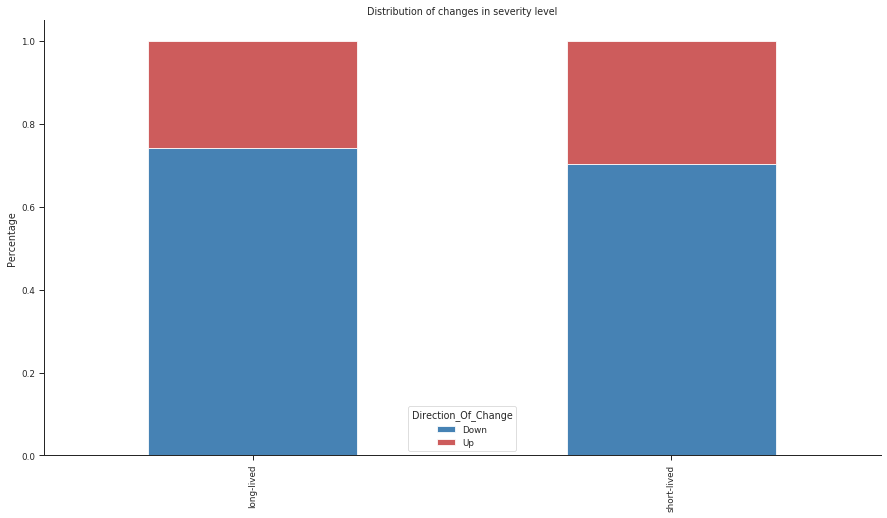

In [65]:
severity_levels = {'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6, 'enhancement':0}
bug_reports_history_merged = pd.merge(
    bug_reports_history_data,
    bug_reports_data[['bug_id', 'creation_date', 'update_date', 'resolution_date', 'bug_fix_time', 'long_lived?']],
    left_on='Key',
    right_on='bug_id',
    how='inner'
)
    
severity_changes_data = bug_reports_history_merged[(bug_reports_history_merged['What'] == 'severity')]
severity_changes_data.loc[:, 'Removed'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Removed']]
severity_changes_data.loc[:, 'Added'] = [severity_levels[level] for level in severity_changes_data.loc[:, 'Added']]
severity_changes_data.loc[:, 'Change'] = severity_changes_data['Added'] - severity_changes_data['Removed']
severity_changes_data.loc[:, 'Direction_Of_Change'] = severity_changes_data['Change'].apply(lambda c: 'Up' if c > 0 else 'Down' if c < 0 else 'No Change')

fig, axes = plt.subplots(figsize=(15,8))
sns.despine()
severity_palette=color=["steelblue", "indianred"]
severity_changes_data = severity_changes_data.groupby("long_lived?")['Direction_Of_Change'].value_counts(normalize=True).unstack()
severity_changes_data.plot(kind='bar', stacked='True', color=severity_palette, ax=axes)

axes.set(title="Distribution of changes in severity level", xlabel="", ylabel="Percentage")

#sns.catplot(x="Change", col="long_lived?",data=severity_changes_data, kind="count",height=8, aspect=1);



In [66]:
bug_reports_history_data[(bug_reports_history_data['What'] == 'assignee')]

,Key,Who,When,What,Removed,Added
188,WINE-88,jim,2000-10-30,assignee,bugs,fgouget
189,WINE-88,jim,2000-10-30,assignee,fgouget,jsheets
196,WINE-88,jim,2001-11-20,assignee,jsheets,susan
466,WINEHQ.ORG-3187,jonathan,2005-11-02,assignee,wine-bugs,jnewman
523,WINE-18057,us,2010-09-06,assignee,wine-bugs,us
525,WINE-18057,us,2012-01-25,assignee,us,wine-bugs
989,WINE-2793,fenix,2005-03-15,assignee,wine-bugs,mike
1065,WINE-182,fgouget,2001-05-05,assignee,bugs,fgouget
1162,WINE-4165,aric,2006-01-12,assignee,wine-bugs,aric
1199,WINE-33989,jacek,2015-02-16,assignee,jacek,wine-bugs


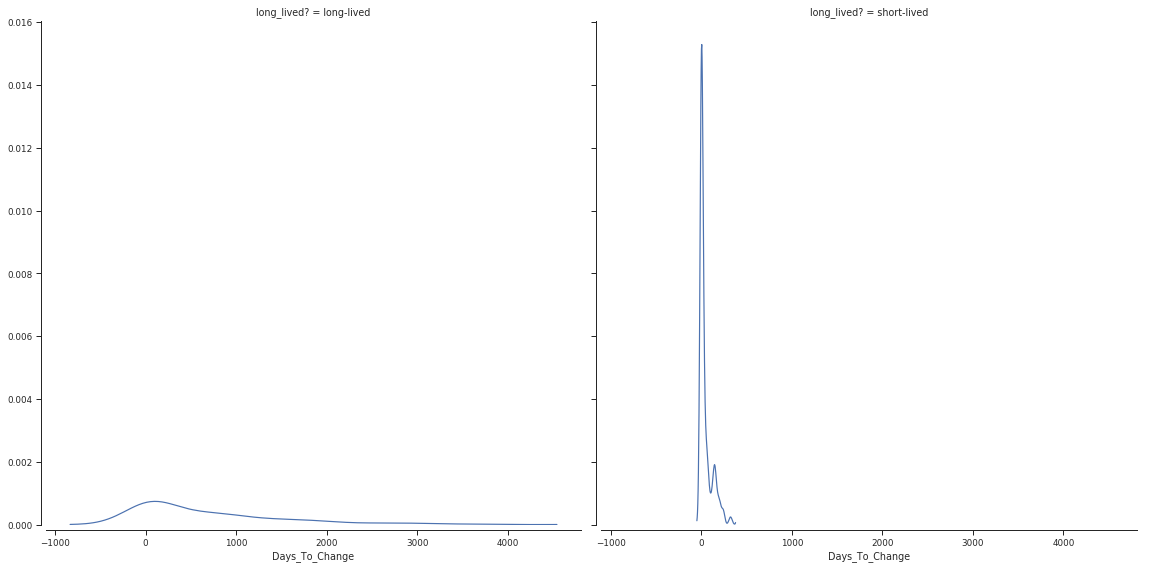

In [67]:
assignee_filter = (bug_reports_history_data['What'] == 'assignee') & (bug_reports_history_merged['Removed'].str.find("bugs") != -1)
assignee_changes_data = bug_reports_history_merged[assignee_filter]
assignee_changes_data.loc[:, 'When'] = pd.to_datetime(assignee_changes_data.loc[:, 'When'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'creation_date'] = pd.to_datetime(assignee_changes_data['creation_date'], format='%Y-%m-%d')
assignee_changes_data.loc[:, 'Days_To_Change'] = (assignee_changes_data['When'] - assignee_changes_data['creation_date']).dt.days

g = sns.FacetGrid(assignee_changes_data, col="long_lived?", height=8, aspect=1)
g.despine(offset=5)
g.map(sns.distplot, "Days_To_Change", hist=False, rug=False);
g.add_legend()


In [69]:
assignee_changes_data.loc[((assignee_changes_data['Days_To_Change'] > 365) & (assignee_changes_data['long_lived?'] == "short-lived")), :]

,Key,Who,When,What,Removed,Added,bug_id,creation_date,update_date,resolution_date,bug_fix_time,long_lived?,Days_To_Change
